In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from dataflow import df_train, df_test, df_geography, df_product



In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError

In [7]:
import sys
print("Python Interpreter Path:", sys.executable)


Python Interpreter Path: c:\Users\Hưng Tăng\AppData\Local\Programs\Python\Python312\python.exe


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Chuyển cột Date sang kiểu datetime
df_train['Date'] = pd.to_datetime(df_train['Date'], errors='coerce')
df_test['Date'] = pd.to_datetime(df_test['Date'], errors='coerce')

# Xử lý lỗi nếu có giá trị NaT
df_train.dropna(subset=['Date'], inplace=True)
df_test.dropna(subset=['Date'], inplace=True)

# Tính số ngày kể từ ngày đầu tiên trong tập train
min_date = df_train['Date'].min()
df_train['Date'] = (df_train['Date'] - min_date).dt.days
df_test['Date'] = (df_test['Date'] - min_date).dt.days

# Chia df_train thành train (80%) và val (20%)
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=42)

# Chọn features và labels
features = ['ProductID', 'Date', 'Zip', 'COGS']
targets = ['Units', 'Revenue']

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(df_train[features])
X_val = scaler_X.transform(df_val[features])
X_test = scaler_X.transform(df_test[features])  # Dùng tập test để dự đoán

y_train = scaler_y.fit_transform(df_train[targets])
y_val = scaler_y.transform(df_val[targets])
y_test = scaler_y.transform(df_test[targets])  # Dùng để đánh giá mô hình


In [9]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 20  # Dùng 20 ngày trước đó để dự đoán ngày tiếp theo

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)  # Tập này sẽ dùng để dự đoán


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
import numpy as np

# 🔹 Hàm loss tách riêng Units và Revenue
def custom_loss(y_true, y_pred):
    mse = MeanSquaredError()
    loss_units = mse(y_true[:, 0], y_pred[:, 0])  # Loss cho Units
    loss_revenue = mse(y_true[:, 1], y_pred[:, 1])  # Loss cho Revenue
    return loss_units + loss_revenue  # Tổng loss

# 🔹 Callback để in loss riêng biệt cho cả train và validation
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super(CustomCallback, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # 🔹 Dự đoán trên tập train
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_train_true = self.y_train

        # 🔹 Dự đoán trên tập validation
        y_val_pred = self.model.predict(self.X_val, verbose=0)
        y_val_true = self.y_val

        mse = MeanSquaredError()

        # 🔹 Tính loss Units & Revenue cho tập train
        loss_units_train = mse(y_train_true[:, 0], y_train_pred[:, 0]).numpy()
        loss_revenue_train = mse(y_train_true[:, 1], y_train_pred[:, 1]).numpy()

        # 🔹 Tính loss Units & Revenue cho tập validation
        loss_units_val = mse(y_val_true[:, 0], y_val_pred[:, 0]).numpy()
        loss_revenue_val = mse(y_val_true[:, 1], y_val_pred[:, 1]).numpy()

        print(f"📊 Epoch {epoch+1} | Train: Loss Units = {loss_units_train:.4f}, Loss Revenue = {loss_revenue_train:.4f} "
              f"| Val: Loss Units = {loss_units_val:.4f}, Loss Revenue = {loss_revenue_val:.4f}")

# 🔹 Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(y_train_seq.shape[1])  # 2 đầu ra: Units & Revenue
])

# 🔹 Compile mô hình với custom loss
model.compile(optimizer='adam', loss=custom_loss)

# 🔹 Huấn luyện mô hình với callback mới
custom_callback = CustomCallback(X_train_seq, y_train_seq, X_val_seq, y_val_seq)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32,
    callbacks=[custom_callback]
)


c:\Users\Hưng Tăng\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
22536/22539 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0630e-04📊 Epoch 1 | Train: Loss Units = 0.0001, Loss Revenue = 0.0002 | Val: Loss Units = 0.0001, Loss Revenue = 0.0002
22539/22539 ━━━━━━━━━━━━━━━━━━━━ 218s 10ms/step - loss: 3.0629e-04 - val_loss: 2.4582e-04
Epoch 2/50
22537/22539 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3257e-04📊 Epoch 2 | Train: Loss Units = 0.0001, Loss Revenue = 0.0002 | Val: Loss Units = 0.0001, Loss Revenue = 0.0002
22539/22539 ━━━━━━━━━━━━━━━━━━━━ 253s 11ms/step - loss: 2.3258e-04 - val_loss: 2.4830e-04
Epoch 3/50
22535/22539 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2887e-04📊 Epoch 3 | Train: Loss Units = 0.0001, Loss Revenue = 0.0002 | Val: Loss Units = 0.0001, Loss Revenue = 0.0002
22539/22539 ━━━━━━━━━━━━━━━━━━━━ 233s 10ms/step - loss: 2.2887e-04 - val_loss: 2.4823e-04
Epoch 4/50
22533/22539 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4030e-04📊 Epoch 4 | Train: Loss Units = 0.0001, Loss Revenue = 0.0002 | Val: Loss Units = 0.0001, Loss Rev

KeyboardInterrupt: 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

def evaluate_model(model, X_test_seq, y_test_seq, scaler_y, labels=["Units", "Revenue"]):
    """
    Dự đoán trên tập test, xử lý NaN, đánh giá bằng MAPE, RMSE, R^2 và vẽ biểu đồ đường.
    
    Args:
        model: Mô hình đã train.
        X_test_seq: Dữ liệu test đã được tạo sequence.
        y_test_seq: Ground truth của tập test.
        scaler_y: Bộ scaler dùng để đưa giá trị về dạng gốc.
        labels: Tên các chỉ số cần đánh giá (Units, Revenue).
    """
    # Dự đoán trên tập test
    y_pred_scaled = model.predict(X_test_seq)
    
    # Chuyển dữ liệu dự đoán và ground truth về dạng gốc
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_orig = scaler_y.inverse_transform(y_test_seq)

    # Kiểm tra NaN trong cả y_pred và y_test_orig
    if np.isnan(y_pred).any() or np.isnan(y_test_orig).any():
        print("⚠️ Cảnh báo: Có NaN trong dữ liệu! Sẽ thay thế bằng giá trị trung bình.")

        # Tính giá trị trung bình của từng cột, bỏ qua NaN
        col_means_pred = np.nanmean(y_pred, axis=0)
        col_means_test = np.nanmean(y_test_orig, axis=0)

        # Thay thế NaN trong y_pred
        for i in range(y_pred.shape[1]):
            y_pred[:, i] = np.where(np.isnan(y_pred[:, i]), col_means_pred[i], y_pred[:, i])

        # Thay thế NaN trong y_test_orig
        for i in range(y_test_orig.shape[1]):
            y_test_orig[:, i] = np.where(np.isnan(y_test_orig[:, i]), col_means_test[i], y_test_orig[:, i])

    # Đánh giá mô hình
    for i, label in enumerate(labels):
        # Tính toán các chỉ số đánh giá
        mape = mean_absolute_percentage_error(y_test_orig[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], y_pred[:, i]))
        r2 = r2_score(y_test_orig[:, i], y_pred[:, i])

        # In kết quả đánh giá
        print(f"{label} - MAPE: {mape:.4f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

        # Vẽ biểu đồ đường
        plt.figure(figsize=(10, 4))
        plt.plot(y_test_orig[:, i], label="Thực tế", linestyle='solid', color='blue')
        plt.plot(y_pred[:, i], label="Dự đoán", linestyle='dashed', color='red')
        plt.title(f"Biểu đồ dự đoán {label}")
        plt.xlabel("Thời gian")
        plt.ylabel(label)
        plt.legend()
        plt.grid(True)
        plt.show()


2334/2334 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
⚠️ Cảnh báo: Có NaN trong dữ liệu! Sẽ thay thế bằng giá trị trung bình.
Units - MAPE: 0.0728, RMSE: 0.23, R²: -0.0356


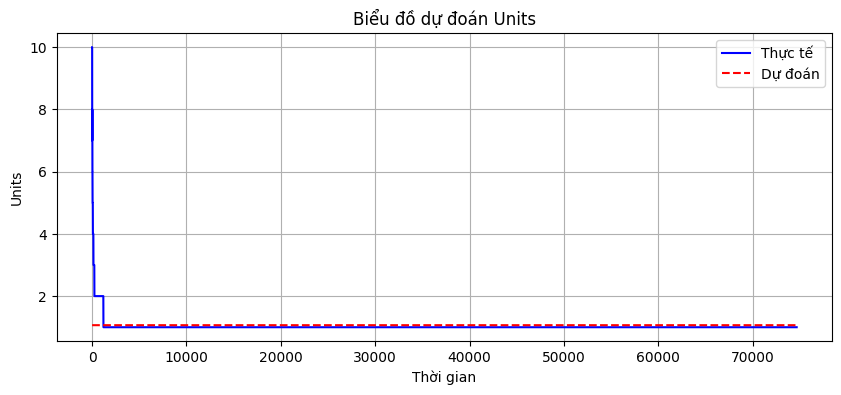

Revenue - MAPE: 0.7907, RMSE: 6143.55, R²: -0.2662


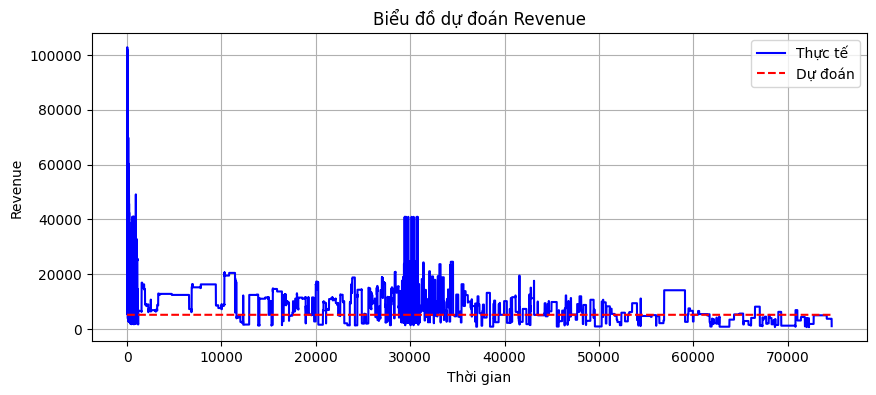

In [27]:
evaluate_model(model, X_test_seq, y_test_seq, scaler_y)


In [28]:
# save model
model.save('lstm1_model.h5')